# ELAIS-N1 Luminosity Function

Use the depth maps to get a histogram of areas with a given depth.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
708e28f (Tue May 8 18:05:21 2018 +0100)
This notebook was executed on: 
2018-05-10 16:59:39.449385


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM



import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

In [3]:
os.environ['GAMA_DATA'] = 'We are not using GAMA data'
#from luminosity_function.gal_sample import CosmoLookup

In [4]:
FIELD = 'ELAIS-N1'
FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"
DMU_DIR = '/mnt/hedam/dmu_products/'
#DMU_DIR = '/Users/rs548/GitHub/dmu_products/'

In [5]:
depths = Table.read("{}dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits".format(DMU_DIR))
final_cat = Table.read("{}dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016.fits".format(DMU_DIR))

## I - Histogram of areas


In [6]:
depths = depths["hp_idx_O_13", 
                "hp_idx_O_10", 
                "ferr_ap_irac_i1_mean", 
                "f_ap_irac_i1_p90", 
                "ferr_irac_i1_mean", 
                "f_irac_i1_p90"]

(0, 5.0)

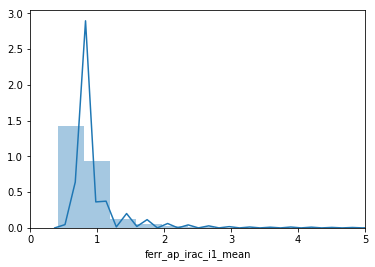

In [7]:
depth_hist_plot = sns.distplot(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])])
depth_hist_plot.set_xlim(0,5.)

In [8]:
bins = np.linspace(0.,2.,1000)
depth_histogram = np.histogram(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])], bins)

In [9]:
np.max(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])])

19.785714285714285

In [10]:
depth_histogram[1][:-1]

array([0.        , 0.002002  , 0.004004  , 0.00600601, 0.00800801,
       0.01001001, 0.01201201, 0.01401401, 0.01601602, 0.01801802,
       0.02002002, 0.02202202, 0.02402402, 0.02602603, 0.02802803,
       0.03003003, 0.03203203, 0.03403403, 0.03603604, 0.03803804,
       0.04004004, 0.04204204, 0.04404404, 0.04604605, 0.04804805,
       0.05005005, 0.05205205, 0.05405405, 0.05605606, 0.05805806,
       0.06006006, 0.06206206, 0.06406406, 0.06606607, 0.06806807,
       0.07007007, 0.07207207, 0.07407407, 0.07607608, 0.07807808,
       0.08008008, 0.08208208, 0.08408408, 0.08608609, 0.08808809,
       0.09009009, 0.09209209, 0.09409409, 0.0960961 , 0.0980981 ,
       0.1001001 , 0.1021021 , 0.1041041 , 0.10610611, 0.10810811,
       0.11011011, 0.11211211, 0.11411411, 0.11611612, 0.11811812,
       0.12012012, 0.12212212, 0.12412412, 0.12612613, 0.12812813,
       0.13013013, 0.13213213, 0.13413413, 0.13613614, 0.13813814,
       0.14014014, 0.14214214, 0.14414414, 0.14614615, 0.14814

[Text(0,0.5,'N'), Text(0.5,0,'ferr_ap_irac_i1_mean (uJ)')]

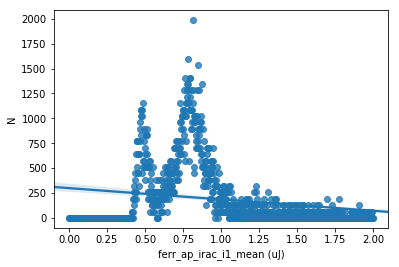

In [11]:
ax = sns.regplot(depth_histogram[1][:-1], depth_histogram[0])
ax.set(xlabel='ferr_ap_irac_i1_mean (uJ)', ylabel='N')

In [12]:
Vmax = Table.read(DMU_DIR + 'dmu28/dmu28_ELAIS-N1/data/zphot/HELP_final_results.fits')#['id']
Vmax['id'].name = 'help_id'
Vmax = Vmax['help_id','UVoptIR_bayes.dust.luminosity', 'UVoptIR_bayes.dust.luminosity_err']

In [13]:
Vmax[:10].show_in_notebook()

idx,help_id,UVoptIR_bayes.dust.luminosity,UVoptIR_bayes.dust.luminosity_err
0,HELP_J155631.108+545024.379,2.198169421792902e+36,1.0663852408249705e+36
1,HELP_J155634.050+545728.087,7.650637925801326e+36,1.5970113316289962e+36
2,HELP_J155635.416+545104.554,3.244561267305129e+38,5.496212040065152e+37
3,HELP_J155643.789+545434.542,5.324129424654964e+37,8.495595121241911e+36
4,HELP_J155644.449+545428.304,1.7308412654885122e+37,5.16574656922523e+36
5,HELP_J155645.249+550054.367,2.5455348239298913e+38,7.152740023424394e+37
6,HELP_J155645.430+544835.225,3.069129676091064e+38,5.711586616131259e+37
7,HELP_J155647.331+550054.897,2.4740858218950754e+38,7.7436208811361745e+37
8,HELP_J155647.710+545045.424,5.027260627724687e+35,6.152251650897128e+34
9,HELP_J155651.625+545843.028,9.675005851837388e+37,4.57263773951873e+37


## II. First calaculate the irac_i1 flux as a function of redshift for each object

In [14]:
#linearly spaced z - should this be logspace?
redshifts = np.linspace(0, 4, 100)
Vmax.add_column(Column(data=np.full((len(Vmax), len(redshifts)), 
                                    np.full(len(redshifts), np.nan)
                                   ) , 
                       name='f_z_relation'
                      )
               )

In [15]:
Vmax[:10].show_in_notebook()

idx,help_id,UVoptIR_bayes.dust.luminosity,UVoptIR_bayes.dust.luminosity_err,f_z_relation [100]
0,HELP_J155631.108+545024.379,2.198169421792902e+36,1.0663852408249705e+36,nan .. nan
1,HELP_J155634.050+545728.087,7.650637925801326e+36,1.5970113316289962e+36,nan .. nan
2,HELP_J155635.416+545104.554,3.244561267305129e+38,5.496212040065152e+37,nan .. nan
3,HELP_J155643.789+545434.542,5.324129424654964e+37,8.495595121241911e+36,nan .. nan
4,HELP_J155644.449+545428.304,1.7308412654885122e+37,5.16574656922523e+36,nan .. nan
5,HELP_J155645.249+550054.367,2.5455348239298913e+38,7.152740023424394e+37,nan .. nan
6,HELP_J155645.430+544835.225,3.069129676091064e+38,5.711586616131259e+37,nan .. nan
7,HELP_J155647.331+550054.897,2.4740858218950754e+38,7.7436208811361745e+37,nan .. nan
8,HELP_J155647.710+545045.424,5.027260627724687e+35,6.152251650897128e+34,nan .. nan
9,HELP_J155651.625+545843.028,9.675005851837388e+37,4.57263773951873e+37,nan .. nan


In [16]:
redshifts = np.linspace(0, 4, 100)
n_absent = 0
n_processed = 0

for gal in Vmax['help_id']:

    try:
        orig_spec = Table.read("{}{}{}_best_model.fits".format(DMU_DIR, 
                                              'dmu28/dmu28_ELAIS-N1/data/zphot/best_model_fits/',
                                              gal
                                             ))
        
    except FileNotFoundError:
        n_absent += 1
        # print('fail')
        continue
        
    #print('{} no fail'.format(gal))
    s = SED()
    # This is wrong because the best SED we get from CIGALE is redshifted (written by Yannick)
    s.add_contribution("HELP_SED", orig_spec['wavelength'], orig_spec['L_lambda_total'])
    
    fluxes = []
    for r in redshifts:
        sed = s.copy()
        mod = get_module("redshifting", redshift=r)
        mod.process(sed)
        fluxes.append(sed.compute_fnu('IRAC1'))
        
    Vmax['f_z_relation'][Vmax['help_id'] == gal] = fluxes
        
    #print("{}:{}".format(gal,fluxes[0]))
    n_processed +=1

In [17]:
print('{} processed and {} missing'.format(n_processed, n_absent))

50129 processed and 0 missing


## III. Then calculate the zmax for each depth bin for each object

Given the array of fluxes as a function of redhsift we interpolate at the depths based on taking the redshift that the object would have a flux equal to 5$\sigma$ for that mean error bin

In [18]:
#Example object left over as the last object from the previous loop
np.interp(5 * bins *1.e-3, np.flip(fluxes,0), np.flip(redshifts,0))

array([4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.     

In [19]:
Vmax.add_column(Column(data=np.full((len(Vmax), len(bins)), 
                                    np.full(len(bins), np.nan)
                                   ) , 
                       name='zmax_histogram'
                      )
               )

In [20]:
for gal in Vmax['help_id']:
    fluxes = np.array(Vmax[Vmax['help_id']==gal]['f_z_relation'])[0]
    z_max_f_relation = np.interp(5 * bins *1.e-3, np.flip(fluxes,0), np.flip(redshifts,0))
    Vmax['zmax_histogram'][Vmax['help_id'] == gal] = z_max_f_relation

Lets check the test object above is correct

In [21]:
np.array(Vmax[Vmax['help_id']=='HELP_J155700.909+550039.328']['zmax_histogram'])[0]

array([4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       3.97000923, 3.91069402, 3.85585164, 3.80247588, 3.74759718,
       3.69361973, 3.64378939, 3.59827304, 3.55633336, 3.51692262,
       3.48085935, 3.4457803 , 3.41089885, 3.37651511, 3.34290257,
       3.30999618, 3.27755546, 3.24596417, 3.2162372 , 3.18816005,
       3.162073  , 3.1366375 , 3.11164496, 3.08737437, 3.06325983,
       3.03945346, 3.01577235, 2.99216944, 2.96924202, 2.94665682,
       2.92578887, 2.90525627, 2.88606653, 2.86707049, 2.84993431,
       2.83279813, 2.81658164, 2.80069418, 2.7848756 , 2.76934438,
       2.75381316, 2.73875464, 2.72402204, 2.70928944, 2.69504105,
       2.68087851, 2.66671596, 2.65249153, 2.63826688, 2.62421

## IV. Finally calculate the Vmax on EN1 for each object
For every object calculate the Vmax for each depth cell and multiply by the number of cells at that depth

In [22]:
Vmax.add_column(Column(data=np.full((len(Vmax), len(bins)), 
                                    np.full(len(bins), np.nan)
                                   ) , 
                       name='vmax_histogram'
                      )
               )

In [23]:
cosmo = FlatLambdaCDM(H0=100. , Om0 = (1-0.7))

#TODO: Make a lookup table for speed

In [24]:
for gal in Vmax['help_id']:
    
    z_max_f_relation = np.array(Vmax[Vmax['help_id']==gal]['zmax_histogram'])[0]
    v_max_f_relation = cosmo.comoving_volume(z_max_f_relation)
    Vmax['vmax_histogram'][Vmax['help_id'] == gal] = v_max_f_relation.value
    
    

In [25]:
Vmax.write("data/vmax_ELAIS-N1.fits", overwrite=True)

In [26]:
#def gal_sample(z0,z1,Ldust,Vmax):
    